## **Data Modeling**


In this notebook, the data is used to train a classification model.

This model is proposed to improve the metrics of complete rate and average transactions.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functions.functions as aux_fun

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import make_column_selector, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, PoissonRegressor

pd.options.mode.chained_assignment = None 

#### **Reading data**

In [2]:
# Read data

# Portifolio and profile datasets
portfolio = pd.read_csv('data_treated/portfolio.csv')
profile = pd.read_csv('data_treated/profile_clustered.csv')

# User and offer data, exported in the notebook Data Exploration
user_offer_df = pd.read_csv('data_treated/user_offer_expanded.csv').astype(
    {'offer_id_rec':np.int8, 'age': np.float64, 'income':np.float64}
    )

Quick look at the data

In [3]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1


In [4]:
profile.head(2)

,gender,age,id,became_member_on,income,user_id,rela_member_years,user_cluster
0,NI,55,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45,0
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03,2


In [5]:
user_offer_df.head(2)

,offer_id_rec,user_id,valid_view_rate,completed_after_view_rate,tra_offer_infl,offer_type,gender,age,income,rela_member_years,user_cluster,age_quartile,income_quartile,member_years_quartile
0,7,3,1.0,0.0,49.39,informational,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
1,3,3,1.0,1.0,19.89,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"


### **Modeling**

Data modeling will be made the two main metrics: complete rate and avarage transactions.  

#### **Complete Rate**

##### Data Preparation

Some users have received repeated offers during the experiment.They may have completed a part of these received offers, which generates complemented_after_view_rate values, such as 0.6, 0.25, for example.


For the classification modeling, two classes will be considered for complete rate. If the user has reached any of the received offers, then receive 1. If not, 0.   

This contour in the data allows modeling, in addition to not changing the overall goal, it is to sort when a class of users will complete an offer.

In [6]:
user_offer_df.loc[user_offer_df.completed_after_view_rate > 0, 'completed_after_view_rate'] = 1 

user_offer_df['completed_after_view_rate'].value_counts()

0.0    42247
1.0    21041
Name: completed_after_view_rate, dtype: int64

In [7]:
# Summarize the necessary columns of user-offer
complete_df = user_offer_df[['offer_id_rec', 'completed_after_view_rate', 
    'offer_type', 'gender', 'age', 'income', 'rela_member_years', 'user_cluster']]

# For modeling, filter out informational offer, since the complete
# rate is always 0, because this offer has no chance of being complete
complete_df = complete_df.loc[complete_df['offer_type']!='informational']

complete_df.head(3)

,offer_id_rec,completed_after_view_rate,offer_type,gender,age,income,rela_member_years,user_cluster
1,3,1.0,bogo,F,75.0,100000.0,1.21,2
2,0,1.0,bogo,F,75.0,100000.0,1.21,2
3,8,0.0,bogo,F,75.0,100000.0,1.21,2


##### Split dataset

In [8]:
# Target features and others
y = complete_df['completed_after_view_rate'] # target
X = complete_df.drop(columns='completed_after_view_rate') # features

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Train

In [9]:
# Create a pipeline

# Transformer
# For Age, Income and Time as Member use a scaler (z score)
sca = StandardScaler()
# For categorical columns, as offer id, offer type, user cluster and gender
# user one hot encoder to create dummy variables.
encoder = OneHotEncoder(sparse=False, dtype='int', handle_unknown='ignore')

# Classifier
# Use Decision Tree to fit data. Class weight is set to balanced to
# balance the size of each class in dataset.
clf = DecisionTreeClassifier(class_weight='balanced')


# Column Transformer chain, since the columns will receive different
# transformations. For numeric columns, the type is float64.
transformers = make_column_transformer( 
    (sca, make_column_selector(dtype_include=np.float64)),
    (encoder, make_column_selector(dtype_exclude=np.float64))
)

# Pipeline
model_complete = Pipeline(
    [
        ('tranformer', transformers),
        ('classifier', clf)
    ]
)

# Fit model to train data
model_complete.fit(X_train, y_train)

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8441F57C0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8441F58E0>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

##### Test

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     20704
         1.0       0.99      0.99      0.99     14741

    accuracy                           0.99     35445
   macro avg       0.99      0.99      0.99     35445
weighted avg       0.99      0.99      0.99     35445



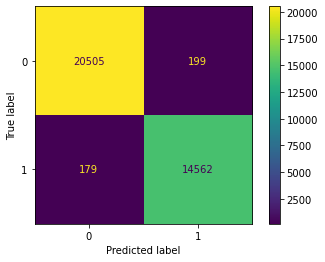

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      8892
         1.0       0.57      0.57      0.57      6300

    accuracy                           0.64     15192
   macro avg       0.63      0.63      0.63     15192
weighted avg       0.64      0.64      0.64     15192



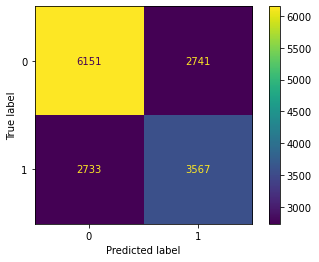

In [10]:
# Evaluation of results
aux_fun.evaluate_model(model_complete, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

The metric chosen to evaluate the model is the recall. Recall accounts for the percentage of true positives over the number of true positive and false negatives (the total real positives). In this way, this metric allows you to tell how much the model can hit reality.  

It is noted that with the training data, the percentage of the model is 99%, while for the test is 59%.

What seems to happen is an overfitting to training data. With that, the model hits the training very well, but it make mistakes a lot in the test and may not apply to new data, never seen.  

One of the parameters of a decision tree that causes this type of behavior is the depth of the tree. So this is a good parameter to be inserted into a grid search in order to find the best value to fit the data

##### Grid Search

In [11]:
# Get params names
print(model_complete.get_params())

{'memory': None, 'steps': [('tranformer', ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8441F57C0>),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='int',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8441F58E0>)])), ('classifier', DecisionTreeClassifier(class_weight='balanced'))], 'verbose': False, 'tranformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8441F57C0>),
                                ('onehotencoder',
                                 OneHotEncoder(dtype='in

In [12]:
# Use GridSearch to search for the best depth of the tree
params_grid = {
    'classifier__max_depth':range(5,40), 
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearch
pipeline_complete_gs = GridSearchCV(model_complete, params_grid, scoring='recall_micro')

# Fit
pipeline_complete_gs.fit(X_train, y_train)

# Best result
model_complete_gs = pipeline_complete_gs.best_estimator_

In [13]:
# Observe the best model
model_complete_gs

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D84477B190>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D84477B430>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=8))])

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74     20704
         1.0       0.64      0.69      0.66     14741

    accuracy                           0.71     35445
   macro avg       0.70      0.71      0.70     35445
weighted avg       0.71      0.71      0.71     35445



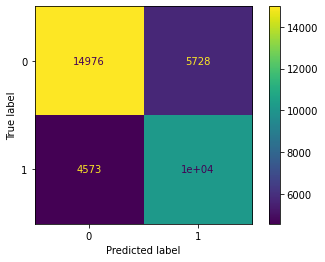

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.75      0.70      0.73      8892
         1.0       0.61      0.67      0.64      6300

    accuracy                           0.69     15192
   macro avg       0.68      0.69      0.68     15192
weighted avg       0.69      0.69      0.69     15192



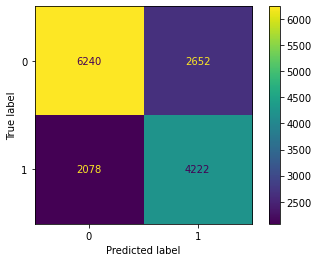

In [14]:
# Evaluate the grid serach best model
aux_fun.evaluate_model(model_complete_gs, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

The recall ran from 59% to around 70%.

The result can be considered low for a model. However, the data worked is from a simulation of 30 days of offers. The time space is short, which may not be an ideal ground to make the fit.  
Thus, this value is considered usable for the purpose of the project. It is considered that the model will fit well into new data, minimally predicting a good result. With more data, the model is able to improve the percentage of recall.

##### Evaluation

One of the possible evaluations in a trained decision tree is the importance of the variables for the tree

In [15]:
# Looking at the importance of each variable in the classification
def create_df_feature_importances(model):
    '''
    Create a dataframe with the variables' importances
    '''
    df_feature = pd.DataFrame()
    df_feature['Variable'] = model.named_steps['tranformer'].get_feature_names_out()
    df_feature['Variable'] = df_feature['Variable'].map(lambda n: n.split('__')[1])
    
    df_feature['Importance'] = model.named_steps['classifier'].feature_importances_
    return df_feature

# Using the function
create_df_feature_importances(model_complete_gs).sort_values('Importance', ascending=False).head(10)

,Variable,Importance
2,rela_member_years,0.266907
15,gender_NI,0.200989
6,offer_id_rec_4,0.127967
7,offer_id_rec_5,0.100711
1,income,0.098148
8,offer_id_rec_6,0.097957
9,offer_id_rec_8,0.052387
0,age,0.030119
14,gender_M,0.019800
5,offer_id_rec_3,0.001985


It is also possible to plot the tree decision path

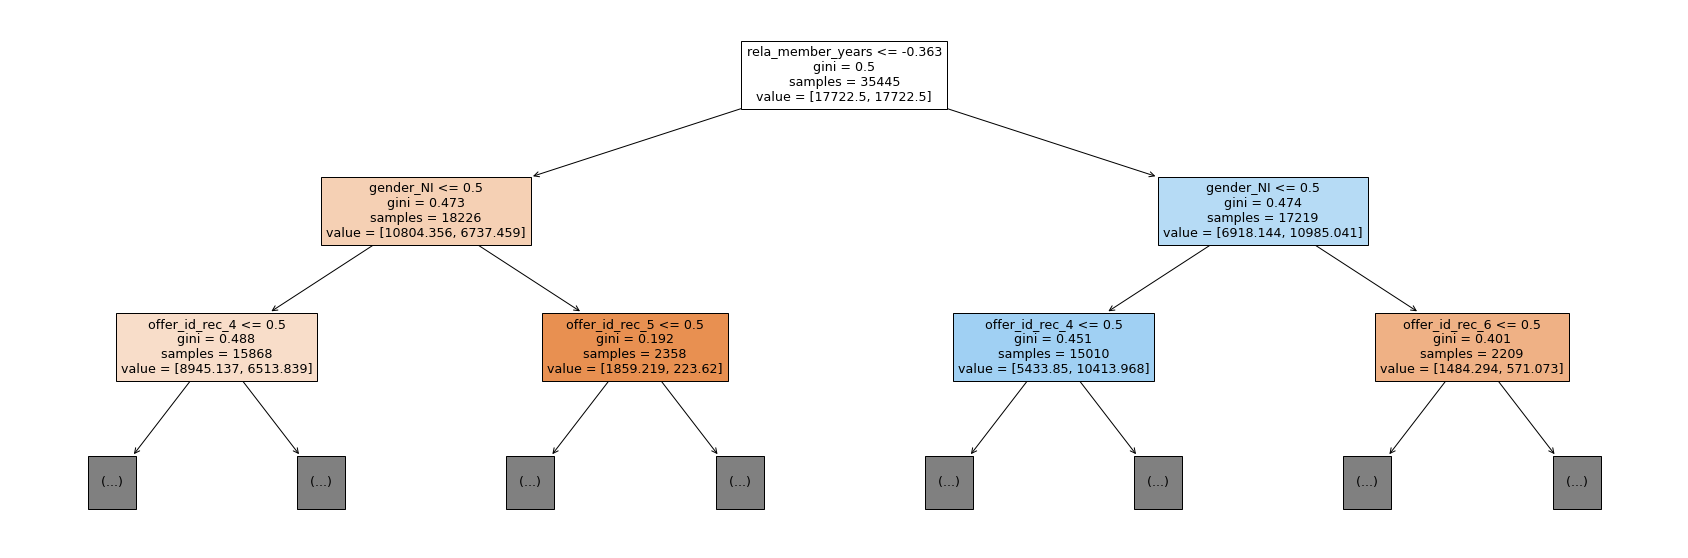

In [16]:
# Viewing the tree

# Get variables names
named_variables =  model_complete_gs.named_steps['tranformer'].get_feature_names_out()
named_variables = [ name.split('__')[1] for name in named_variables]

# Get tree from model
clf_tree = model_complete_gs.named_steps['classifier']

# Plot tree
plt.figure(figsize=(30,10))
plot_tree(clf_tree, max_depth=2, feature_names=named_variables, filled=True)
plt.show()

By the table, it is noted that the unidentified genre is the second feature in importance.This is because there are few users, which becomes easy to divide larger groups.  

First is the time as a member. This feature is the first to be used in the division of the tree. Although standarized, it is noted that low values make the first division. That is, users with little time as a member divide groups with more classes 0.

After them, see offers 4, 5 and 6. These offers are the discount type and have a great impact on the separation of classes.

##### Deployment

This model can be used to guide offers to users.

The function below does this. Operation is based on the operation:  
1. Filters the Profile Base with an Entrda User ID  
2. Simulates this user receives all offers  
3. Creates a column with the planned complete class  
4. Offers that are planned to be complete are returns  

In [17]:
def best_user_offer_to_send(user, model, X):
    '''
    Function to return the best deals for a user.
    Input:
        user - (int) An user id
        model- (sklearn model) A model trained to predict complete offers
    Output:
        recs - (list) A list of best offers to the user
    Description:
        This function simulate the user receiving all offers and use the model
        to predict the completation.
    '''

    # Filter user in profile
    user_df = profile.loc[profile['user_id'] == user]
    # Select columns
    user_df = user_df[['gender', 'age', 'income', 'rela_member_years', 'user_cluster']]
    
    # Create a simulation to deliver all offers to the user
    offers_df = portfolio[['offer_id', 'offer_type']]
    offers_df.columns = ['offer_id_rec', 'offer_type']
    offers_df = aux_fun.expand_dataframe(user_df, offers_df)

    # Garantee order of columns
    offers_df = offers_df[X.columns]
    
    # Predict
    offers_df['complete_pred'] = model.predict(offers_df)
    
    # Filter
    best_offers = offers_df.loc[offers_df['complete_pred'] == 1]

    # Create list
    recs = []
    for _, row in best_offers.iterrows():
        recs.append(str(row['offer_id_rec']) +\
            ' - ' + str(row['offer_type']))
    
    print(f'Offers for {user}: {recs}')
    
    return recs

In [18]:
# Applying the function for the five first users
for user in range(0,5):
    best_user_offer_to_send(user, model_complete_gs, X)

Offers for 0: ['5 - discount', '6 - discount', '8 - bogo']
Offers for 1: ['0 - bogo', '1 - bogo', '2 - informational', '3 - bogo', '5 - discount', '6 - discount', '7 - informational', '8 - bogo', '9 - discount']
Offers for 2: []
Offers for 3: ['0 - bogo', '1 - bogo', '2 - informational', '3 - bogo', '4 - discount', '5 - discount', '6 - discount', '7 - informational', '8 - bogo', '9 - discount']
Offers for 4: []


For the user with id = 2, there are no offers that the forecast model that would be completed. This result can change over time.  

For user 0, the offers with the chance of being complete are 5 and 6, while for user 1, all offers have people to complete by the user profile.

#### **Transactions**  

The previous model can be combined with a regression model for the total transactions from the supply sent to each user

##### Data preparation

In [19]:
# Transactions
transactions_df = user_offer_df[['offer_id_rec','tra_offer_infl', 'offer_type', 'gender',
       'age', 'income', 'rela_member_years', 'user_cluster']]

transactions_df.head(3)

,offer_id_rec,tra_offer_infl,offer_type,gender,age,income,rela_member_years,user_cluster
0,7,49.39,informational,F,75.0,100000.0,1.21,2
1,3,19.89,bogo,F,75.0,100000.0,1.21,2
2,0,21.72,bogo,F,75.0,100000.0,1.21,2


##### Split dataset 

In [20]:
# Target features and others
y = transactions_df['tra_offer_infl'] # target
X = transactions_df.drop(columns='tra_offer_infl') # features

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Train

In [21]:
# Create a pipeline

# Transformer
# For Age, Income and Time as Member use a scaler (z score)
sca = StandardScaler()
# For categorical columns, as offer id, offer type, user cluster and gender
# user one hot encoder to create dummy variables.
encoder = OneHotEncoder(sparse=False, dtype='int', handle_unknown='ignore')

# Classifier
# Use LinearRegression to fit data.
reg = LinearRegression() # standart reg

# Column Transformer chain, since the columns will receive different
# transformations. For numeric columns, the type is float64.
transformers = make_column_transformer( 
    (sca, make_column_selector(dtype_include=np.float64)),
    (encoder, make_column_selector(dtype_exclude=np.float64))
)

# Pipeline
model_reg = Pipeline(
    [
        ('tranformer', transformers),
        ('regressor', reg)
    ]
)

# Fit model to train data
model_reg.fit(X_train, y_train)

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8480266D0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001D8480263D0>)])),
                ('regressor', LinearRegression())])

##### Test

Perfomance with Train

R2: 0.033865765807816195
Perfomance with Test

R2: 0.037587931408534225
Residuals plot


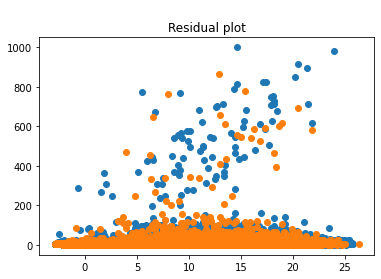

In [22]:
# Evaluation of results
aux_fun.evaluate_model_reg(model_reg, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

The regression has terrible results for the R².This metric counts as the model can explain from the total variation of the data.

As you see, with R² near 0.03, the regression model is not usable.

Observing the data, what happens is the excess of training data close to 0.  
In this way, the model does not have many data to adjust the data in general.  

The charts below shows the values.

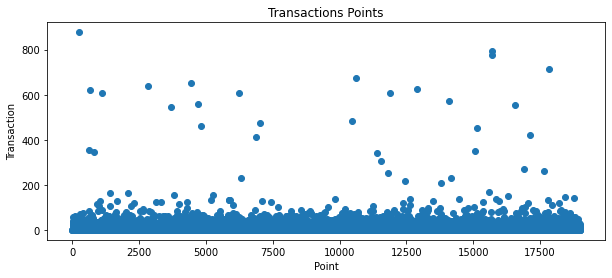

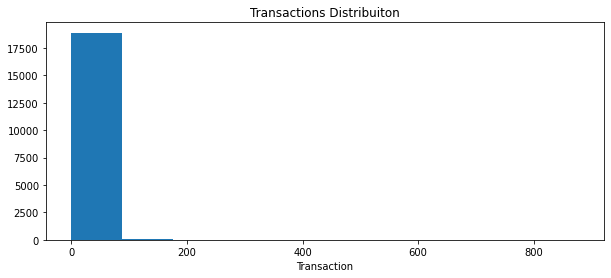

In [23]:
# Plotting the y train data

# Data points
plt.figure(figsize=(10,4))
x = np.arange(len(y_test))
plt.scatter(x, y_test)
plt.title('Transactions Points'); plt.xlabel('Point'); plt.ylabel('Transaction')
plt.show()
# Histogram
plt.figure(figsize=(10,4))
plt.hist(y_test)
plt.title('Transactions Distribuiton'); plt.xlabel('Transaction')
plt.show()

Como observado, para os dados trabalhados, um modelo de regressão não se encaixa bem.  




##### Changing the model

A strategy to be able to enable the use of the transaction variables is to adpt the template to the classification model.

The change consists of considering that any transaction, that is, transaction values above zero, are evidence that the user has shopped influenced by that offer. Thus, two classes are divided:  

* 0: there were no transactions. tra_offer_infl == 0.
* 1: there was some transaction. tra_offer_infl > 0.


##### Redefining the data and split train and test

In [24]:
# Redefing the data

# Target features and others
y = transactions_df[['tra_offer_infl']] # target
X = transactions_df.drop(columns='tra_offer_infl') # features

# Classing the transactions
y.loc[y['tra_offer_infl'] > 0, 'tra_offer_infl'] = 1  

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Train new model

In [25]:
# Create a pipeline

# Transformer
# For Age, Income and Time as Member use a scaler (z score)
sca = StandardScaler()
# For categorical columns, as offer id, offer type, user cluster and gender
# user one hot encoder to create dummy variables.
encoder = OneHotEncoder(sparse=False, dtype='int')

# Classifier
# Use Decision Tree to fit data. Class weight is set to balanced to
# balance the size of each class in dataset.
clf = DecisionTreeClassifier(class_weight='balanced')


# Column Transformer chain, since the columns will receive different
# transformations. For numeric columns, the type is float64.
transformers = make_column_transformer( 
    (sca, make_column_selector(dtype_include=np.float64)),
    (encoder, make_column_selector(dtype_exclude=np.float64))
)

# Pipeline
model_tra = Pipeline(
    [
        ('tranformer', transformers),
        ('classifier', clf)
    ]
)

# Use GridSearch to search for the best depth of the tree
params_grid = {
    'classifier__max_depth':range(5,40), 
    'classifier__criterion': ['gini', 'entropy'] 
}

# GridSearch
pipeline_gs = GridSearchCV(model_tra, params_grid, scoring='recall_micro')

# Fit
pipeline_gs.fit(X_train, y_train)

# Best result
model_tra_gs = pipeline_gs.best_estimator_

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69     20719
         1.0       0.73      0.71      0.72     23582

    accuracy                           0.70     44301
   macro avg       0.70      0.70      0.70     44301
weighted avg       0.70      0.70      0.70     44301



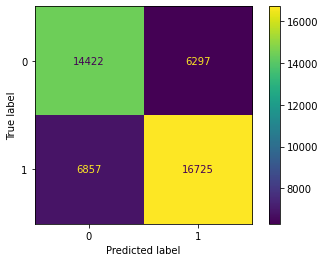

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68      8866
         1.0       0.72      0.70      0.71     10121

    accuracy                           0.69     18987
   macro avg       0.69      0.69      0.69     18987
weighted avg       0.69      0.69      0.69     18987



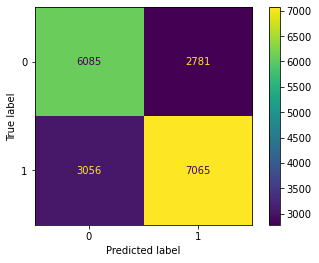

In [26]:
# Evaluation of results
aux_fun.evaluate_model(model_tra_gs, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

The classification of the transaction delivers a rebate around 60%.  
Again, a theoretically low, but feasible result of being used in the project, since the goal is that the model fits well into data has never seen.


##### Evaluation

In [27]:
# Importance variables in the model
# Using the function
create_df_feature_importances(model_tra_gs).sort_values('Importance', ascending=False).head(10)

,Variable,Importance
2,rela_member_years,0.183760
7,offer_id_rec_4,0.147371
1,income,0.141623
12,offer_id_rec_9,0.124871
6,offer_id_rec_3,0.118014
5,offer_id_rec_2,0.116954
15,offer_type_informational,0.074634
0,age,0.055401
3,offer_id_rec_0,0.008368
9,offer_id_rec_6,0.007445


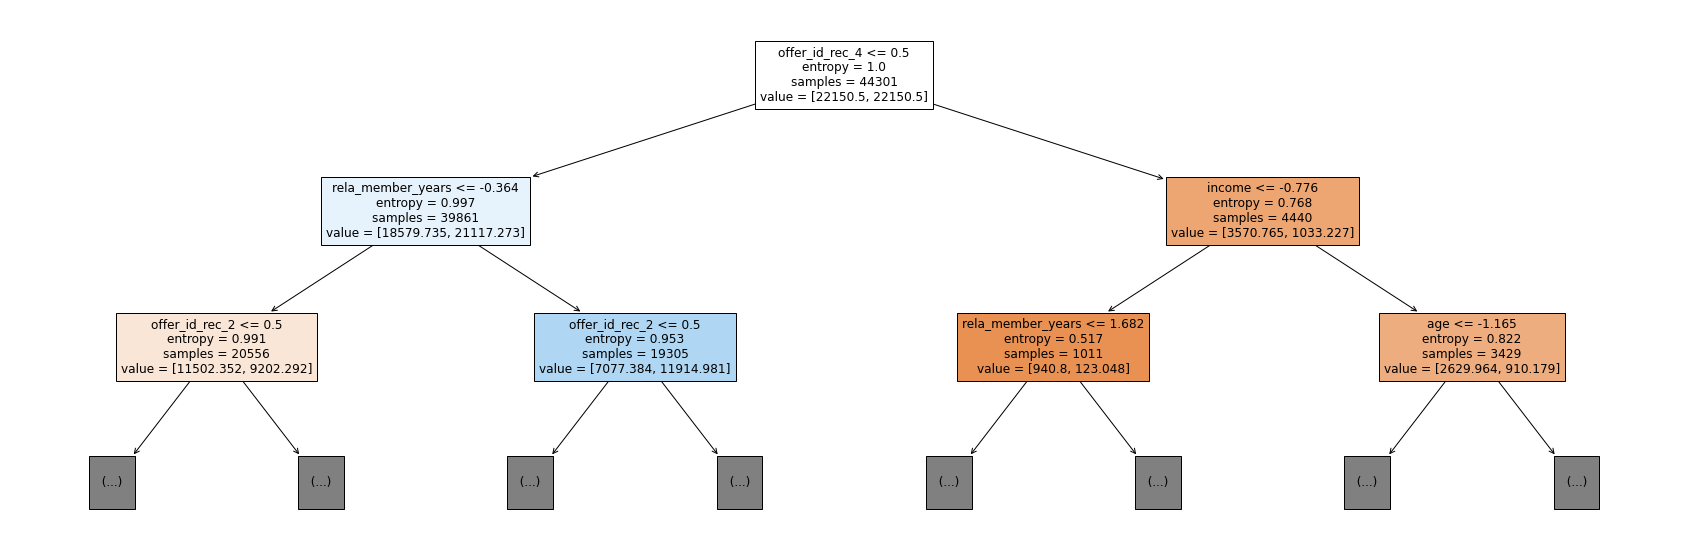

In [28]:
# Viewing the tree

# Get variables names
named_variables =  model_tra_gs.named_steps['tranformer'].get_feature_names_out()
named_variables = [ name.split('__')[1] for name in named_variables]

# Get tree from model
clf_tree = model_tra_gs.named_steps['classifier']

# Plot tree
plt.figure(figsize=(30,10))
plot_tree(clf_tree, max_depth=2, feature_names=named_variables, filled=True)
plt.show()

For the transaction model, the first vaulting that works to split the groups is the ID 4 offer.

The most important, revealed in the table, is the time variable as a member, again appearing as important in the class division.  

The most important third variable has a logic in the evaluation, which is income. As seen in data exploration, users with larger lace will transaction more compared to minors.

### **Deployment**  

The two models created above can be combined for delivery the best directing from offers to users.

The idea is to combine when a user is predict to complete the offer and transact values because of the offer.

In [29]:
# Improving the prior function with a second model

def best_user_offer_to_send2(user, model_completation, model_transaction, X):
    '''
    Function to return the best deals for a user.
    Input:
        user - (int) An user id
        model_completation - (sklearn model) A model trained to predict
        complete offers
        model_transaction - (sklearn model) A model trained to predict
        transaction because an offer
    Output:
        recs - (list) A list of best offers to the user
    Description:
        This function simulate the user receiving all offers and use the models
        to predict the completation and transaction. A score column is created
        to account for best offers (==1)
    '''
    
    # Filter user in profile
    user_df = profile.loc[profile['user_id']==user]
    # Select columns
    user_df = user_df[['gender', 'age', 'income', 'rela_member_years', 'user_cluster']]
    
    # Create a simulation to deliver all offers to the user
    offers_df = portfolio[['offer_id', 'offer_type']]
    offers_df.columns = ['offer_id_rec', 'offer_type']
    offers_df = aux_fun.expand_dataframe(user_df, offers_df)

    # Garantee order of columns
    offers_df = offers_df[X.columns]
    
    # Predict Completation
    offers_df['complete_pred'] = model_completation.predict(offers_df)
    # Predict Transactions
    offers_df['transaction_pred'] = model_transaction.predict(offers_df)
    
    # Create a score column and filter
    offers_df['score'] = offers_df['complete_pred']*offers_df['transaction_pred']
    best_offers = offers_df.loc[offers_df['score'] == 1]

    # Create list
    recs = []
    for _, row in best_offers.iterrows():
        recs.append(str(row['offer_id_rec']) +\
            ' - ' + str(row['offer_type']))
    
    print(f'Offers for {user}: {recs}')
    
    return recs

In [30]:
# For the first 5 users

for user in range(0,5):
    best_user_offer_to_send2(user, model_complete_gs, model_tra_gs, X)

Offers for 0: ['5 - discount', '6 - discount', '8 - bogo']
Offers for 1: ['0 - bogo', '1 - bogo', '5 - discount', '6 - discount', '8 - bogo']
Offers for 2: []
Offers for 3: ['0 - bogo', '1 - bogo', '5 - discount', '6 - discount', '8 - bogo']
Offers for 4: []


As noted, the recommendation values were reduced to user 0 and also for users 1 and 3.  
This is because with this new transaction classification model, the function only offers offers with both expected positive classes.